In [1]:
""" reference: http://savvastjortjoglou.com/nfl-draft.html """

' reference: http://savvastjortjoglou.com/nfl-draft.html '

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from urllib.request import urlopen
from bs4 import BeautifulSoup

In [89]:
from functools import reduce

# Web Scraping

In [33]:
# The url we will be scraping
url_1967 = "http://www.pro-football-reference.com/years/1967/draft.htm"

# get the html
html = urlopen(url_1967)

# create the BeautifulSoup object
soup = BeautifulSoup(html, "lxml")

# Scraping the Column Headers

In [34]:
# Extract the necessary values for the column headers from the table
# and store them as a list
column_headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]

# Add the two additional column headers for the player links
column_headers.extend(["Player_NFL_Link", "Player_NCAA_Link"])

In [35]:
column_headers

['Rnd',
 'Pick',
 'Tm',
 'Player',
 'Pos',
 'Age',
 'To',
 'AP1',
 'PB',
 'St',
 'CarAV',
 'DrAV',
 'G',
 'Cmp',
 'Att',
 'Yds',
 'TD',
 'Int',
 'Att',
 'Yds',
 'TD',
 'Rec',
 'Yds',
 'TD',
 'Int',
 'Sk',
 'College/Univ',
 '',
 'Player_NFL_Link',
 'Player_NCAA_Link']

# Scraping the Data

In [36]:
# The data is found within the table rows of the element with id=draft
# We want the elements from the 3rd row and on
table_rows = soup.select("#drafts tr")[2:]

In [38]:
type(table_rows)

list

In [39]:
table_rows[0]

<tr><th class="right " data-stat="draft_round" scope="row">1</th><td class="right " csk="0.5" data-stat="draft_pick">1</td><td class="left " csk="clt01" data-stat="team"><a href="/teams/clt/1967_draft.htm" title="Baltimore Colts">BAL</a></td><td class="left " csk="Smith,Bubba" data-append-csv="SmitBu00" data-stat="player"><a href="/players/S/SmitBu00.htm">Bubba Smith</a></td><td class="left " csk="DE--------0001" data-stat="pos">DE</td><td class="right " data-stat="age">22</td><td class="right " data-stat="year_max">1976</td><td class="right " data-stat="all_pros_first_team">1</td><td class="right " data-stat="pro_bowls">2</td><td class="right " data-stat="years_as_primary_starter">6</td><td class="right " data-stat="career_av">63</td><td class="right " data-stat="draft_av">47</td><td class="right " data-stat="g">111</td><td class="right iz" data-stat="pass_cmp">0</td><td class="right iz" data-stat="pass_att">0</td><td class="right iz" data-stat="pass_yds">0</td><td class="right iz" da

In [57]:
table_rows[0].find_all(["th", "td"])

[<th class="right " data-stat="draft_round" scope="row">1</th>,
 <td class="right " csk="0.5" data-stat="draft_pick">1</td>,
 <td class="left " csk="clt01" data-stat="team"><a href="/teams/clt/1967_draft.htm" title="Baltimore Colts">BAL</a></td>,
 <td class="left " csk="Smith,Bubba" data-append-csv="SmitBu00" data-stat="player"><a href="/players/S/SmitBu00.htm">Bubba Smith</a></td>,
 <td class="left " csk="DE--------0001" data-stat="pos">DE</td>,
 <td class="right " data-stat="age">22</td>,
 <td class="right " data-stat="year_max">1976</td>,
 <td class="right " data-stat="all_pros_first_team">1</td>,
 <td class="right " data-stat="pro_bowls">2</td>,
 <td class="right " data-stat="years_as_primary_starter">6</td>,
 <td class="right " data-stat="career_av">63</td>,
 <td class="right " data-stat="draft_av">47</td>,
 <td class="right " data-stat="g">111</td>,
 <td class="right iz" data-stat="pass_cmp">0</td>,
 <td class="right iz" data-stat="pass_att">0</td>,
 <td class="right iz" data-sta

In [40]:
type(table_rows[0])

bs4.element.Tag

In [41]:
table_rows[0].getText()

'11BALBubba SmithDE221976126634711100000000000Michigan St.College Stats'

In [42]:
table_rows[0].get_text()

'11BALBubba SmithDE221976126634711100000000000Michigan St.College Stats'

In [58]:
def extract_player_data(table_rows):
    """
    Extract and return the desired information from the td elements within
    the table rows.
    """
    # create the empty list to store the player data
    player_data = []
    
    # for each row do the following
    for row in table_rows:
        # Get the text for each table data (td) element in the row
        # Some player names end with ' HOF', if they do, get the text excluding
        # those last 4 characters,
        # otherwise get all the text data from the table data
        player_list = [td.get_text()[:-4] 
                       if td.get_text().endswith(" HOF") 
                       else td.get_text() for td in row.find_all(["th", "td"])]
        
        # there are some empty table rows, which are the repeated
        # column headers in the table
        # we skip over those rows and continue the for loop
        if not player_list:
            continue
            
        # Extracting the player links
        # Instead of a list we create a dictionary, this way we can easily
        # match the player name with their pfr url
        # For all "a" elements in the row, get the text
        # NOTE: Same " HOF" tet issue as the player_list above
        links_dict = {(link.get_text()[:-4]  # exclude the last 4 characters
                       if link.get_text().endswith(" HOF")  # if they are " HOF"
                       # else get all text, set that as the dictionary key
                       # and set the url as the value
                       else link.get_text()): link["href"] 
                      for link in row.find_all("a", href=True)}
        
        # The data we want from the dictionary can be extracted using the
        # player's name, which returns us their pfr url, and "College Stats"
        # which returns us their college stats page
        
        # add the link associated to the player's pro-football-reference page,
        # or an empty string if there is no link
        player_list.append(links_dict.get(player_list[3], ""))
        
        # add the link for the player's college stats or an empty string
        # if there is no link
        player_list.append(links_dict.get("College Stats", ""))
        
        # Now append the data to list of data
        player_data.append(player_list)
    
    return player_data

In [59]:
# extract the data we want
data = extract_player_data(table_rows)

# and then store it in a DataFrame
df_1967 = pd.DataFrame(data, columns=column_headers)

In [61]:
df_1967.head()

,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,St,...,TD,Rec,Yds,TD,Int,Sk,College/Univ,,Player_NFL_Link,Player_NCAA_Link
0,1,1,BAL,Bubba Smith,DE,22,1976,1,2,6,...,0,0,0,0,,,Michigan St.,College Stats,/players/S/SmitBu00.htm,http://www.sports-reference.com/cfb/players/bu...
1,1,2,MIN,Clint Jones,RB,22,1973,0,0,2,...,20,38,431,0,,,Michigan St.,College Stats,/players/J/JoneCl00.htm,http://www.sports-reference.com/cfb/players/cl...
2,1,3,SFO,Steve Spurrier,QB,22,1976,0,0,6,...,2,0,0,0,,,Florida,College Stats,/players/S/SpurSt00.htm,http://www.sports-reference.com/cfb/players/st...
3,1,4,MIA,Bob Griese,QB,22,1980,2,8,12,...,7,0,0,0,,,Purdue,College Stats,/players/G/GrieBo00.htm,http://www.sports-reference.com/cfb/players/bo...
4,1,5,HOU,George Webster,LB,21,1976,3,3,6,...,0,0,0,0,5,,Michigan St.,College Stats,/players/W/WebsGe00.htm,http://www.sports-reference.com/cfb/players/ge...


# Scraping the Data for All Seasons Since 1967

In [132]:
# Create an empty list that will contain all the dataframes
# (one dataframe for each draft)
draft_dfs_list = []

# a list to store any errors that may come up while scraping
errors_list = []

In [133]:
# The url template that we pass in the draft year inro
url_template = "http://www.pro-football-reference.com/years/{year}/draft.htm"

# for each year from 1967 to (and including) 2016
for year in range(1967, 2017):
    
    # use try/except block to catch and inspect any urls that cause an error
    try:
        # get the draft url
        url = url_template.format(year=year)
        
        # get the html
        html = urlopen(url)
        
        # create the BeautifulSoup object
        soup = BeautifulSoup(html, "lxml")
        
        # get the column headers
        column_headers = [th.getText() for th in
                          soup.findAll('tr', limit=2)[1].findAll('th')]
        column_headers.extend(["Player_NFL_Link", "Player_NCAA_Link"])
        
        # select the data from the table using the '#drafts tr' CSS selector
        table_rows = soup.select("#drafts tr")[2:]
        
        # extract the player data from the table rows
        player_data = extract_player_data(table_rows)
        
        # create the dataframe for the current years draft
        year_df = pd.DataFrame(player_data, columns=column_headers)
        
        # if it is a draft from before 1994 then add a Tkl column at the
        # 24th position
        if year < 1994:
            year_df.insert(24, "Solo", "")
            
        # add the year of the draft to the dataframe
        year_df.insert(0, "Draft_Yr", year)
        
        # append the current dataframe to the list of dataframes
        draft_dfs_list.append(year_df)
        
    except Exception as e:
        # Store the url and the error it causes in a list
        error = [url, e]
        # then append it to the list of errors
        errors_list.append(error)

In [134]:
len(errors_list)

0

In [135]:
errors_list

[]

In [136]:
for df in draft_dfs_list:
    if df.shape[1] != 32:
        print(df.shape)

In [137]:
len(draft_dfs_list)

50

In [138]:
draft_dfs_list[0].columns

Index(['Draft_Yr', 'Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'Age', 'To', 'AP1',
       'PB', 'St', 'CarAV', 'DrAV', 'G', 'Cmp', 'Att', 'Yds', 'TD', 'Int',
       'Att', 'Yds', 'TD', 'Rec', 'Yds', 'TD', 'Solo', 'Int', 'Sk',
       'College/Univ', '', 'Player_NFL_Link', 'Player_NCAA_Link'],
      dtype='object')

In [139]:
draft_dfs_list[1].columns

Index(['Draft_Yr', 'Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'Age', 'To', 'AP1',
       'PB', 'St', 'CarAV', 'DrAV', 'G', 'Cmp', 'Att', 'Yds', 'TD', 'Int',
       'Att', 'Yds', 'TD', 'Rec', 'Yds', 'TD', 'Solo', 'Int', 'Sk',
       'College/Univ', '', 'Player_NFL_Link', 'Player_NCAA_Link'],
      dtype='object')

In [140]:
draft_dfs_list[26].columns

Index(['Draft_Yr', 'Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'Age', 'To', 'AP1',
       'PB', 'St', 'CarAV', 'DrAV', 'G', 'Cmp', 'Att', 'Yds', 'TD', 'Int',
       'Att', 'Yds', 'TD', 'Rec', 'Yds', 'TD', 'Solo', 'Int', 'Sk',
       'College/Univ', '', 'Player_NFL_Link', 'Player_NCAA_Link'],
      dtype='object')

In [141]:
draft_dfs_list[27].columns

Index(['Draft_Yr', 'Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'Age', 'To', 'AP1',
       'PB', 'St', 'CarAV', 'DrAV', 'G', 'Cmp', 'Att', 'Yds', 'TD', 'Int',
       'Att', 'Yds', 'TD', 'Rec', 'Yds', 'TD', 'Solo', 'Int', 'Sk',
       'College/Univ', '', 'Player_NFL_Link', 'Player_NCAA_Link'],
      dtype='object')

In [142]:
draft_dfs_list[28].columns

Index(['Draft_Yr', 'Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'Age', 'To', 'AP1',
       'PB', 'St', 'CarAV', 'DrAV', 'G', 'Cmp', 'Att', 'Yds', 'TD', 'Int',
       'Att', 'Yds', 'TD', 'Rec', 'Yds', 'TD', 'Solo', 'Int', 'Sk',
       'College/Univ', '', 'Player_NFL_Link', 'Player_NCAA_Link'],
      dtype='object')

In [143]:
# store all drafts in one DataFrame
draft_df = pd.concat(draft_dfs_list[26:28], ignore_index=True)
#reduce(lambda x,y: pd.concat([x,y], ignore_index=True), draft_dfs_list)

In [144]:
draft_df.head()

,Draft_Yr,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,...,Rec,Yds,TD,Solo,Int,Sk,College/Univ,,Player_NFL_Link,Player_NCAA_Link
0,1993,1,1,NWE,Drew Bledsoe,QB,21,2006,0,4,...,1,-9,0,,,,Washington St.,College Stats,/players/B/BledDr00.htm,http://www.sports-reference.com/cfb/players/dr...
1,1993,1,2,SEA,Rick Mirer,QB,23,2003,0,0,...,0,0,0,,,,Notre Dame,College Stats,/players/M/MireRi00.htm,http://www.sports-reference.com/cfb/players/ri...
2,1993,1,3,PHO,Garrison Hearst,RB,22,2004,0,2,...,229,2065,9,,,,Georgia,College Stats,/players/H/HearGa00.htm,http://www.sports-reference.com/cfb/players/ga...
3,1993,1,4,NYJ,Marvin Jones,LB,21,2003,0,0,...,0,0,0,,5,9.0,Florida St.,College Stats,/players/J/JoneMa23.htm,http://www.sports-reference.com/cfb/players/ma...
4,1993,1,5,CIN,John Copeland,DE,22,2000,0,0,...,0,0,0,,3,24.0,Alabama,College Stats,/players/C/CopeJo20.htm,http://www.sports-reference.com/cfb/players/jo...


In [145]:
# get the current column headers from the dataframe as a list
column_headers = draft_df.columns.tolist()

# The 5th column header is an empty string, but represents player names
column_headers[4] = "Player"

# Prepend "Rush_" for the columns that represent rushing stats
column_headers[19:22] = ["Rush_" + col for col in column_headers[19:22]]

# Prepend "Rec_" for the columns that represent receiving stats
column_headers[23:25] = ["Rec_" + col for col in column_headers[23:25]]

# Properly label the defensive int column as "Def_Int"
column_headers[-6] = "Def_Int"

# Just use "College" as the column header represent player's colleger or univ
column_headers[-4] = "College"

# Take a look at the updated column headers
column_headers

['Draft_Yr',
 'Rnd',
 'Pick',
 'Tm',
 'Player',
 'Pos',
 'Age',
 'To',
 'AP1',
 'PB',
 'St',
 'CarAV',
 'DrAV',
 'G',
 'Cmp',
 'Att',
 'Yds',
 'TD',
 'Int',
 'Rush_Att',
 'Rush_Yds',
 'Rush_TD',
 'Rec',
 'Rec_Yds',
 'Rec_TD',
 'Solo',
 'Def_Int',
 'Sk',
 'College',
 '',
 'Player_NFL_Link',
 'Player_NCAA_Link']

In [146]:
# Now assign edited columns to the DataFrame
draft_df.columns = column_headers

In [147]:
# Write out the raw draft data to the raw_data fold in the data folder
draft_df.to_csv("data/raw_data/pfr_nfl_draft_data_RAW.csv", index=False)

# Cleaning the Data

In [150]:
draft_df.Player_NFL_Link

0      /players/B/BledDr00.htm
1      /players/M/MireRi00.htm
2      /players/H/HearGa00.htm
3      /players/J/JoneMa23.htm
4      /players/C/CopeJo20.htm
5      /players/C/CurrEr20.htm
6      /players/C/ConwCu00.htm
7      /players/R/RoafWi00.htm
8      /players/K/KennLi00.htm
9      /players/B/BettJe00.htm
10     /players/W/WillDa20.htm
11     /players/B/BatePa20.htm
12     /players/H/HopkBr00.htm
13     /players/E/EverSt20.htm
14     /players/S/SimmWa20.htm
15     /players/D/DawkSe00.htm
16     /players/C/CartTo20.htm
17     /players/D/DyexEr20.htm
18     /players/H/HolmLe20.htm
19     /players/S/SmitIr00.htm
20     /players/S/SmitRo00.htm
21     /players/G/GordDa20.htm
22     /players/F/FiguDe20.htm
23     /players/R/RenfLe20.htm
24     /players/M/McDuO.00.htm
25     /players/S/StubDa00.htm
26     /players/K/KellTo20.htm
27     /players/S/SmitTh21.htm
28     /players/T/TeagGe20.htm
29                            
                ...           
429    /players/W/WortBa20.htm
430     

In [151]:
# extract the player id from the player links
# expand-False returns the IDs as a pandas Series
player_ids = draft_df.Player_NFL_Link.str.extract("/.*/.*/(.*)\.", expand=False)

In [152]:
# add a Player_ID column to our draft_df
draft_df["Player_ID"] = player_ids

In [153]:
# add the beginning of the pfr url to the player link column
pfr_url = "http://www.pro-football-reference.com"
draft_df.Player_NFL_Link = pfr_url + draft_df.Player_NFL_Link

In [154]:
# Get the Player name, IDs, and links
player_id_df = draft_df.loc[:, ["Player", "Player_ID", "Player_NFL_Link",
                                "Player_NCAA_Link"]]

# Save them to a CSV file
player_id_df.to_csv("data/clean_data/pfr_player_ids_and_links.csv", index=False)

# Cleaning Up the Rest of the Draft Data

In [155]:
# drop the player links and the column labeled by an empty string
draft_df.drop(draft_df.columns[-4:-1], axis=1, inplace=True)

In [156]:
draft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 30 columns):
Draft_Yr     459 non-null int64
Rnd          459 non-null object
Pick         459 non-null object
Tm           459 non-null object
Player       459 non-null object
Pos          459 non-null object
Age          459 non-null object
To           459 non-null object
AP1          459 non-null object
PB           459 non-null object
St           459 non-null object
CarAV        459 non-null object
DrAV         459 non-null object
G            459 non-null object
Cmp          459 non-null object
Att          459 non-null object
Yds          459 non-null object
TD           459 non-null object
Int          459 non-null object
Rush_Att     459 non-null object
Rush_Yds     459 non-null object
Rush_TD      459 non-null object
Rec          459 non-null object
Rec_Yds      459 non-null object
Rec_TD       459 non-null object
Solo         459 non-null object
Def_Int      459 non-null object
Sk   

In [157]:
# convert the data to proper numeric types
draft_df = draft_df.apply(pd.to_numeric, errors='ignore')

In [158]:
draft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 30 columns):
Draft_Yr     459 non-null int64
Rnd          459 non-null object
Pick         459 non-null object
Tm           459 non-null object
Player       459 non-null object
Pos          459 non-null object
Age          459 non-null object
To           459 non-null object
AP1          459 non-null object
PB           459 non-null object
St           459 non-null object
CarAV        459 non-null object
DrAV         459 non-null object
G            459 non-null object
Cmp          459 non-null object
Att          459 non-null object
Yds          459 non-null object
TD           459 non-null object
Int          459 non-null object
Rush_Att     459 non-null object
Rush_Yds     459 non-null object
Rush_TD      459 non-null object
Rec          459 non-null object
Rec_Yds      459 non-null object
Rec_TD       459 non-null object
Solo         459 non-null object
Def_Int      459 non-null object
Sk   

In [159]:
# Get the column names for the numeric columns
num_cols = draft_df.columns[draft_df.dtypes != object]

# Replace all NaNs with 0
draft_df.loc[:, num_cols] = draft_df.loc[:, num_cols].fillna(0)

In [160]:
# Everythong is filled, except for Player_ID, which is fine for now
draft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 30 columns):
Draft_Yr     459 non-null int64
Rnd          459 non-null object
Pick         459 non-null object
Tm           459 non-null object
Player       459 non-null object
Pos          459 non-null object
Age          459 non-null object
To           459 non-null object
AP1          459 non-null object
PB           459 non-null object
St           459 non-null object
CarAV        459 non-null object
DrAV         459 non-null object
G            459 non-null object
Cmp          459 non-null object
Att          459 non-null object
Yds          459 non-null object
TD           459 non-null object
Int          459 non-null object
Rush_Att     459 non-null object
Rush_Yds     459 non-null object
Rush_TD      459 non-null object
Rec          459 non-null object
Rec_Yds      459 non-null object
Rec_TD       459 non-null object
Solo         459 non-null object
Def_Int      459 non-null object
Sk   

In [161]:
draft_df.to_csv("data/clean_data/pfr_nfl_draft_data_CLEAN.csv", index=False)

# Exploring the NFL Draft

In [162]:
# get data for drafts from 1967 to 2010
draft_df_2010 = draft_df.loc[draft_df.Draft_Yr <= 2010, :]

In [163]:
draft_df_2010.tail() # we see that the last draft is 2010

,Draft_Yr,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,...,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,Solo,Def_Int,Sk,College,Player_ID
454,1994,7,218,DEN,Tom Nalen,C,23,2007,2,5,...,0,0,1,-1,0,,,,Boston Col.,NaleTo00
455,1994,7,219,KAN,Tracy Greene,TE,21,1995,0,0,...,0,0,6,69,1,,,,Grambling St.,GreeTr01
456,1994,7,220,HOU,Lemanski Hall,LB,23,2002,0,0,...,0,0,0,0,0,90,,4.0,Alabama,HallLe20
457,1994,7,221,BUF,Filmel Johnson,DB,23,1995,0,0,...,0,0,0,0,0,5,,,Illinois,JohnFi20
458,1994,7,222,NWE,Marty Moore,LB,23,2001,0,0,...,0,0,0,0,0,110,3,1.0,Kentucky,MoorMa23


# The Career Approximate Value distribution

In [165]:
# set some plotting styles
from matplotlib import rcParams

# set the font scaling and the plot sizes
sns.set(font_scale=1.65)
rcParams["figure.figsize"] = 12,9

TypeError: unsupported operand type(s) for /: 'str' and 'int'

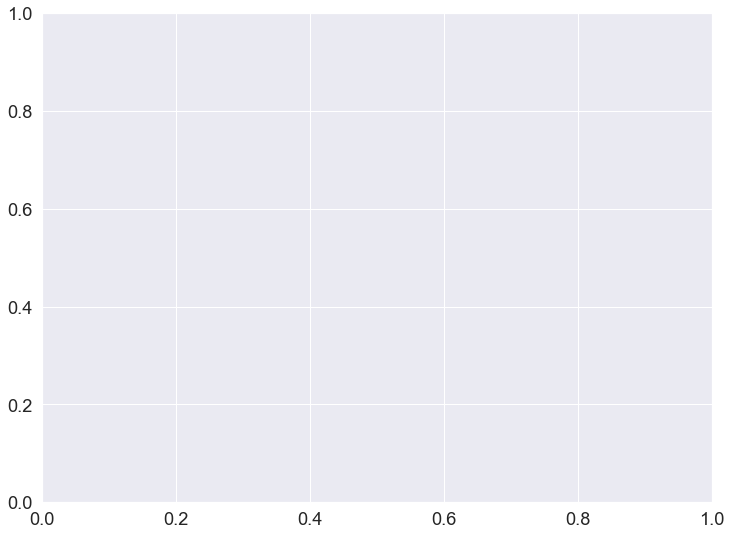

In [166]:
# Use distplot to view the distribution
sns.distplot(draft_df_2010.CarAV)
plt.title("Distribution of Career Approximate Value")
plt.xlim(-5, 150)
plt.show()